## Preparation

### Load data

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import sklearn.linear_model as skl
import sklearn.preprocessing as skp
import os
from matplotlib import pyplot as plt
import copy as cp

BLUE_LIGHT = str('#00CCFF')
GREEN_LIGHT = str('#00CC00')
RED_LIGHT = str('#FF3333')
DATA_DIR = 'data'

In [3]:
data_df = pd.read_csv(os.path.join(DATA_DIR, 'covid_data.csv'))
                  #usecols=['date','case_by_day', 'case_by_time', 'death_by_day', 'death_by_time', 'recovered_by_time'])
data_df['case_by_time'] = data_df['case_by_time'] - data_df['recovered_by_time'] - data_df['death_by_time']

In [4]:
data_df = data_df.iloc[139:,:]
data_df['date'] -= 139

In [5]:
data_df.tail()

,date,case_by_day,case_by_time,death_by_day,death_by_time,recovered_by_day,recovered_by_time,total_injected_by_time,once_injected_by_time,twice_injected_by_time
254,115,16369,330283,166,33515,28369,1465150,147350872,8606523,69457833
255,116,16106,331389,223,33738,14633,1479783,147638276,8453959,69685313
256,117,16260,338461,238,33976,8990,1488773,147678731,8493838,69685313
257,118,15556,349040,197,34173,12210,1500983,147722605,8537436,69685313
258,119,14596,273623,206,34379,89842,1590825,148350360,7980103,70313068


### Visualize

In [218]:
X_date = np.array(data_df['date'].values)
Y_cases =  np.array(data_df['case_by_day'].values)
Y_deaths = np.array(data_df['death_by_day'].values)
Y_recovered = np.array(data_df['recovered_by_time'].values)

print(Y_deaths)

[298 276 215 234 212 219 233 215 240 236 236 203 179 184 177 178 161 219
 377 164 114 130 133 119 120 121 105 113 115  93 106  81  93  88  63  73
  75  72  71  56  76  53  65  64  54  53  56  64  53  48  74  78  59  68
  58  61  66  87  79  84  81  88  64 101  86  67 139 102 107  76 189 167
 124 166 137 147 190 172 196 191 201 198 200 199 210 230 230 253 216 208
 228 239 250 283 241 245 189 214 221 248 209 275 234 237 207 222 210 243
 289 220 216 238 178 219 228 166 223 238 197 206]


In [117]:
# Smooth 7 day - average
def smooth_helper(data_array, k = 7):
    copy = cp.deepcopy(data_array)
    for i in range(int(k/2), len(data_array) - int(k/2)):
        temp = 0
        for j in range(k):
            temp += float(copy[i + j - int(k/2)] / k)
        copy[i] = int(temp)
    return copy.reshape(-1,)

def smooth(data_array, k = 7):
    copy = cp.deepcopy(data_array)
    for col_index in range(data_array.shape[1]):
        copy[:,col_index] = smooth_helper(copy[:,col_index], k)
    return copy


In [118]:
# Draw
def drawCase(X, Y, color):
        plt.figure(figsize=(9,3))
        
        ax = plt.axes()
        #ax.grid(linewidth=0.4, color='#8f8f8f') 
        
        #ax.set_facecolor("black") 
        ax.set_xlabel('\nDate',size=25,color='#4bb4f2')
        ax.set_ylabel('Number of Confirmed Cases\n',
                size=25,color='#4bb4f2')
        
        ax.plot(X,Y,
                color=color,
                linewidth=4,
                markersize=15,
                markeredgecolor=RED_LIGHT)

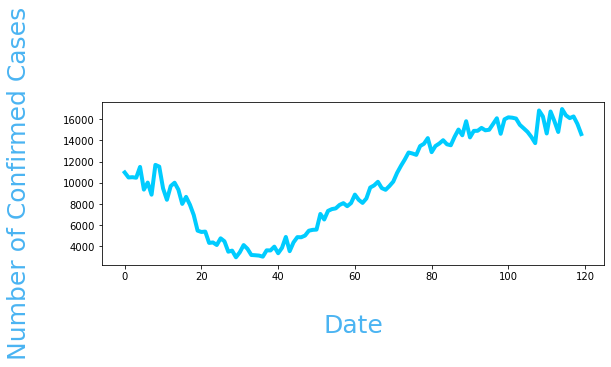

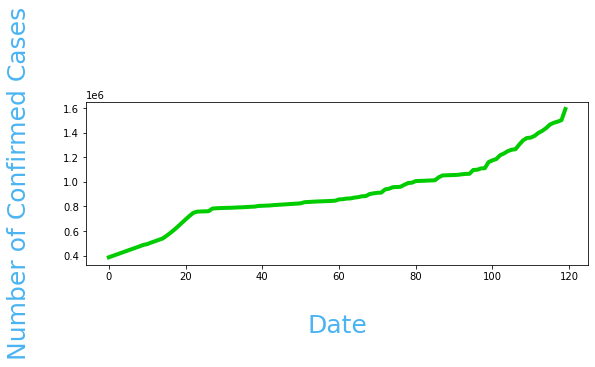

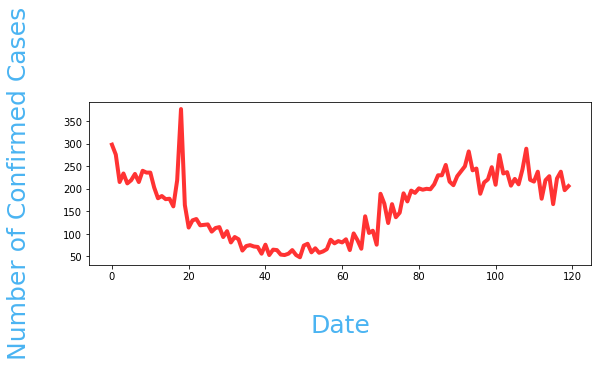

In [119]:
drawCase(X_date, Y_cases, BLUE_LIGHT)
drawCase(X_date, Y_recovered, GREEN_LIGHT)
drawCase(X_date, Y_deaths, RED_LIGHT)

#### Smooth graph

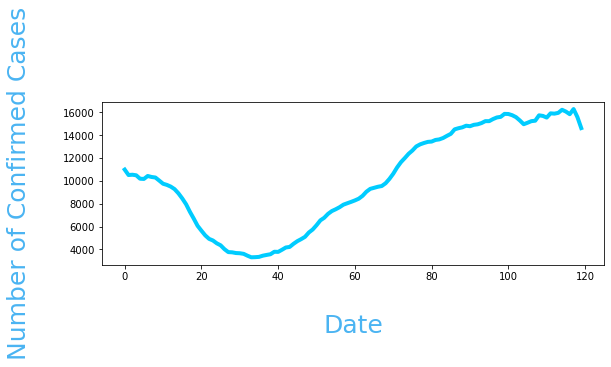

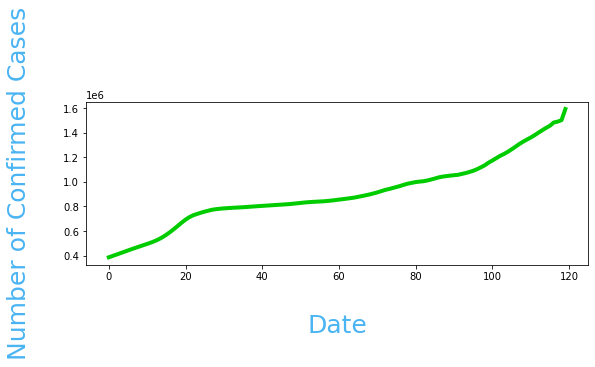

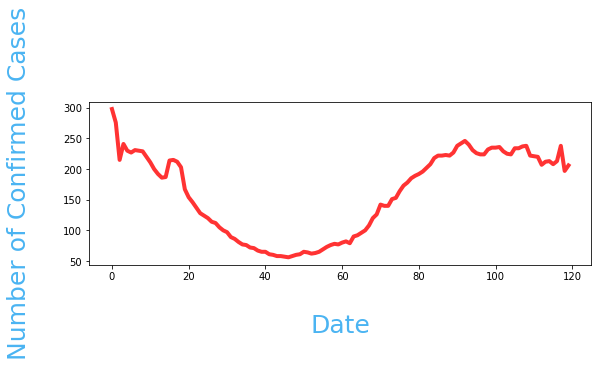

In [129]:
Y_cases_smooth = smooth(Y_cases.reshape(-1,1)).reshape(-1,)
Y_recovered_smooth = smooth(Y_recovered.reshape(-1,1)).reshape(-1,)
Y_deaths_smooth = smooth(Y_deaths.reshape(-1,1)).reshape(-1,)

drawCase(X_date, Y_cases_smooth, BLUE_LIGHT)
drawCase(X_date, Y_recovered_smooth, GREEN_LIGHT)
drawCase(X_date, Y_deaths_smooth, RED_LIGHT)

## Method

### Linear Regression

In [221]:
DAY = 180
future = list(range(DAY))

#### With date

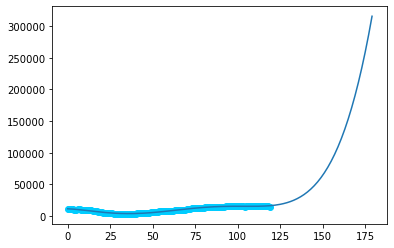

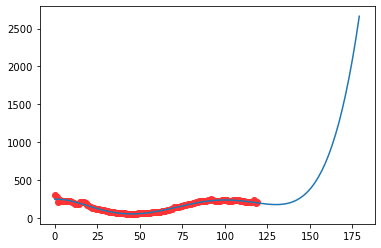

In [222]:
casesModel = np.poly1d(np.polyfit(X_date, Y_cases_smooth, 3))
deathsModel = np.poly1d(np.polyfit(X_date, Y_deaths_smooth, 5))


plt.scatter(X_date, Y_cases_smooth, c=BLUE_LIGHT)
plt.plot(future, casesModel(future))
plt.show()

plt.scatter(X_date, Y_deaths_smooth, c=RED_LIGHT)
plt.plot(future, deathsModel(future))
plt.show()



#### With date and total cases

In [227]:
X = data_df[['date', 'case_by_time']].values
#Y_cases_smooth
#Y_death_smooth

poly = skp.PolynomialFeatures(degree = 3, include_bias=False)
X_poly = poly.fit_transform(X)
regr_cases = skl.LinearRegression()
regr_cases.fit(X_poly, Y_cases_smooth)

regr_deaths = skl.LinearRegression()
regr_deaths.fit(X_poly, Y_deaths_smooth)

LinearRegression()

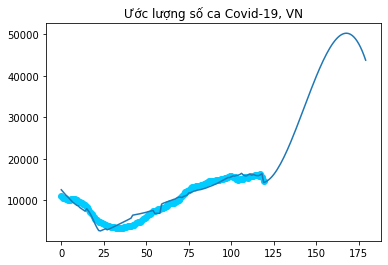

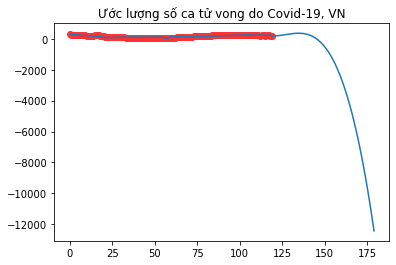

In [229]:
ld = X.shape[0]
predict = np.zeros((DAY, X.shape[-1]), dtype=int)
predict[:ld,:] = X
for i in range(ld, len(predict)):
    day = i
    total_case = predict[i-1,1] + regr_cases.predict(poly.fit_transform([[ld, predict[ld-1,1]]])) - regr_deaths.predict(poly.fit_transform([[ld, predict[ld-1,1]]]))
    predict[i,:] = [day, total_case] 



plt.scatter(X_date, Y_cases_smooth, c=BLUE_LIGHT)
plt.plot(future, regr_cases.predict(poly.fit_transform(predict)))
plt.title("Ước lượng số ca Covid-19, VN")
plt.show()


plt.scatter(X_date, Y_deaths_smooth, c=RED_LIGHT)
plt.plot(future, regr_deaths.predict(poly.fit_transform(predict)))
plt.title("Ước lượng số ca tử vong do Covid-19, VN")
plt.show()


### Gompertz

In [ ]:
def 